# Cognitive Modelling: Homework 4

Name: Vishal Sreenivasan  
Student No.: S4196392

## Importing files & libraries

In [2]:
from model import Model
from dmchunk import Chunk
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random

# Time functions

In [3]:
def noise(s):
    rand = np.random.uniform(0.001,0.999)
    return s * math.log((1 - rand)/rand)

def time_to_pulses(time, t_0 = 0.011, a = 1.1, b = 0.015):
    pulses = 0
    pulse_duration = t_0
    while time >= pulse_duration:
        time = time - pulse_duration
        pulses += 1
        pulse_duration = a * pulse_duration + noise(b * a * pulse_duration)
    return pulses

def pulses_to_time(pulses, t_0 = 0.011, a = 1.1, b = 0.015):
    time = 0
    pulse_duration = t_0
    while pulses > 0:
        time = time + pulse_duration
        pulses = pulses - 1
        pulse_duration = a * pulse_duration + noise(b * a * pulse_duration)
    return time

In [1]:
def return_intervals():
    """
    function to return 
    sample intervals.
    """
    
    #reads J&S data
    df = pd.read_csv("dataJS.csv")
    
    #sorting the unique sample intervals on ascending order
    ts = np.sort(df["Ts"].unique())
    intervals = {"short": ts[0:11],
                "inter": ts[5:16],
                "long": ts[10:]}
    return intervals

def ready_set_go(n_participants, n_train = 500, n_test = 1000):
    """
    ready-set-go base function.
    
    Arguments:
    n_participants: number of participants.
    n_train: number of training steps.
    n_test: number of testing steps.
    """
    
    #intialize dataframe
    df = pd.DataFrame(columns = ["Subj", "Cond", "Trial", "Ts", "Tp", "Main"])
    
    #dataframe index
    index = 0
    
    #set number of trials
    trials = 1500
    
    #3 set of conditions
    conditions = ["short", "inter", "long"]
    
    #retrieving discrete interval distribution
    intervals = return_intervals()
    main = None
    
    for subj in range(n_participants):
        
        #initializing new model for each participant
        
        #randomize conditions
        random.shuffle(conditions)
        
        for cond in conditions:
            
            m = Model()
            
            # Trial loop
            for trial in range(trials):
                
                #initial time
                m.time += 1
                main = False
                
                #random delay of 0.25-0.85 secs
                m.time += np.random.uniform(0.25,0.85)
                
                #randomly choosing a discrete interval
                interval = np.random.choice(intervals[cond])
                
                #converting secs to pulses
                pulse = time_to_pulses(interval/1000)
                
                #input chunk for dm
                fact = Chunk(name = f"rsg{pulse}", slots = {"isa": "rsg-time", "pulse": pulse})
                
                #adding the encounter and interval
                m.time += interval/1000
                m.add_encounter(fact)
                
                #additional time for go
                m.time += 0.010
                
                #request to retrive the pulse from dm
                request = Chunk(name = "blended-test", slots = {"isa": "rsg-time"})
                #retrieving the blended memory out of the rest
                pulse, latency = m.retrieve_blended_trace(request, "pulse")
                
                #adding the latency and the production time
                m.time += latency
                time = pulses_to_time(pulse)
                m.time += time
                
                if trial > 500:
                    main = True
                
                #appending to dataframe
                df.loc[index] = [subj + 1, cond, trial + 1, interval, time * 1000, main]
                index += 1
    return df

In [4]:
df = ready_set_go(5)

In [5]:
df.head()

,Subj,Cond,Trial,Ts,Tp,Main
0,1,short,1,847.01,884.293958,False
1,1,short,2,741.13,974.797583,False
2,1,short,3,811.72,831.145670,False
3,1,short,4,599.96,833.128015,False
4,1,short,5,635.26,637.310355,False


# Plot function

In [6]:
def plot_function(df):
    # Remove training trials
    dat = df[df['Main'] == True]

    # Calculate mean Tp by condition
    mean_tp = dat.groupby(['Cond', 'Ts'])['Tp'].mean().reset_index()


    yrange = np.multiply((min(mean_tp['Ts']), max(mean_tp['Ts'])), [0.95, 1.05])

    # Subset data for plotting

    cond1 = mean_tp.loc[mean_tp['Cond'] == "short"]
    cond2 = mean_tp.loc[mean_tp['Cond'] == "inter"]
    cond3 = mean_tp.loc[mean_tp['Cond'] == "long"]

    # Add jitter noise
    jitter = dat.copy()
    jitter['Ts'] = jitter['Ts'] + np.random.uniform(-5, 5, len(dat))
    cond1_jitter = jitter.loc[jitter['Cond'] == 'short']
    cond2_jitter = jitter.loc[jitter['Cond'] == 'inter']
    cond3_jitter = jitter.loc[jitter['Cond'] == 'long']

    # Make plot
    f, ax = plt.subplots(figsize = (6,6))

    ax.set(xlim = yrange, ylim = yrange)
    f.gca().set_aspect('equal', adjustable = 'box')

    ax.set_xlabel('Sample interval (ms)')
    ax.set_ylabel('Production time (ms)')

    ax.plot(yrange, yrange, linestyle = '--', color ='gray')

    ax.scatter(cond1_jitter['Ts'], cond1_jitter['Tp'], marker = '.', color = 'black', alpha = 0.025, label = None)
    ax.scatter(cond2_jitter['Ts'], cond2_jitter['Tp'], marker = '.', color = 'brown', alpha = 0.025, label = None)
    ax.scatter(cond3_jitter['Ts'], cond3_jitter['Tp'], marker = '.', color = 'red', alpha = 0.025, label = None)

    ax.plot(cond1['Ts'], cond1['Tp'], color = 'black', marker = 'o', label = "short")
    ax.plot(cond2['Ts'], cond2['Tp'], color = 'brown', marker = 'o', label = "intermediate")
    ax.plot(cond3['Ts'], cond3['Tp'], color = 'red', marker = 'o', label = "long")

    ax.legend(title = 'Prior condition', loc = 4)

In [7]:
hw3_df = pd.read_csv("hw3.csv")

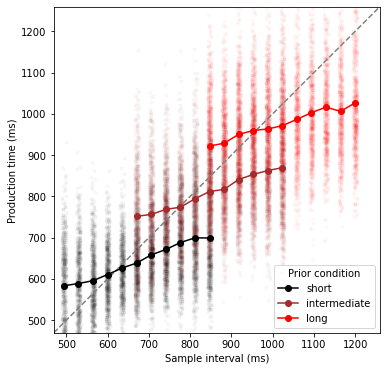

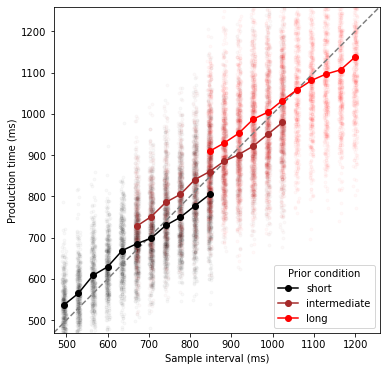

In [8]:
plot_function(hw3_df)
plot_function(df)

# Conclusion

Homework 3 deals with retrieving highest activated memory from the declarative memory. For eg: 848ms is stored more than the rest in the distribution, it becomes highest activated memory even for 1000ms. Thus producing a result with lower slope as shown in the above image (Top). Homework 4 consist of a different retrieval method called blending, which returns a blended trace of all the time intervals (pulses) within the declarative memory.  The resulting graph (bottom) as shown above, represents intervals with larger slope compared to previous assignment. This suggests that the retrieved values are rather close to the input pulse since weighted average of the chunks in declarative memory is selected with the priority of most recently added memory.